# 外卖平台线上门店经营诊断（脱敏公开版）

> 本项目基于某外卖平台（仅线上渠道）一个月订单明细数据，完成从“趋势识别 → 贡献定位 → 量价拆解 → 结构变化验证 → 建议输出”的完整分析闭环。  
> **说明：**仓库不包含任何原始数据；门店、城市等均已脱敏为 `Store_XX / City_X`，仅输出汇总表与图表用于展示。

---

## 1. 项目目标（我想解决什么问题？）
在实际经营中，门店常出现“最近销售下滑但不知道原因”的情况。本项目希望回答三个核心问题：

1) **发生了什么？** GMV（销售额）是否下滑，下滑从什么时候开始？  
2) **是谁导致的？** 下滑是否由少数门店贡献（贡献度/集中度）？  
3) **为什么下滑？** 下滑主要来自订单量（Orders）还是客单价（AOV）？是否存在结构性变化信号（如“一口价”渗透）？

---

## 2. 数据范围与口径（重要前提）
- **渠道范围：**某外卖平台线上订单（不包含线下销售、其他平台销售）  
- **时间范围：**2025-12-29 ～ 2026-01-29  
- **数据粒度：**订单商品明细（后续汇总为“门店×天”与“天”粒度）  
- **关键指标：**  
  - GMV：成交金额（销售额）  
  - Orders：订单数/下单量（注意：在明细表中可能会重复计数，需在聚合口径中统一）  
  - AOV：客单价（GMV / Orders）  
  - Active SKU：动销SKU数（当天有成交记录的不同商品数）  
  - One-price GMV Share：一口价GMV占比（结构性信号）

---

## 3. 分析路线（我按什么逻辑推进？）
本项目采用“业务诊断式”路线：

**趋势（Time Series） → 贡献（Contribution） → 拆解（Decomposition） → 验证（Validation） → 建议（Action）**

这样做的好处是：每一步都能产出可验证的证据（图/表），并逐步缩小问题范围，最后形成可执行建议。


In [12]:
from pathlib import Path
import pandas as pd
from IPython.display import Image, display

# 约定：仓库根目录下有 outputs_public/（图表与公开表都在这里）
OUT_PUBLIC = Path('outputs_public')
if not OUT_PUBLIC.exists():
    # 如果 notebook 在 notebooks/ 目录下
    OUT_PUBLIC = Path('../outputs_public')

assert OUT_PUBLIC.exists(), f'找不到 outputs_public 文件夹：{OUT_PUBLIC.resolve()}'
print('OUT_PUBLIC:', OUT_PUBLIC.resolve())


OUT_PUBLIC exists: True
OUT_PUBLIC path: E:\Project\store-sales-project\outputs_public


## 3.1 总览趋势：GMV 与 Orders 发生了什么？
先从最直观的趋势入手，观察整体GMV与订单量是否存在同步下滑、是否存在异常峰值日（例如节假日/活动日）。


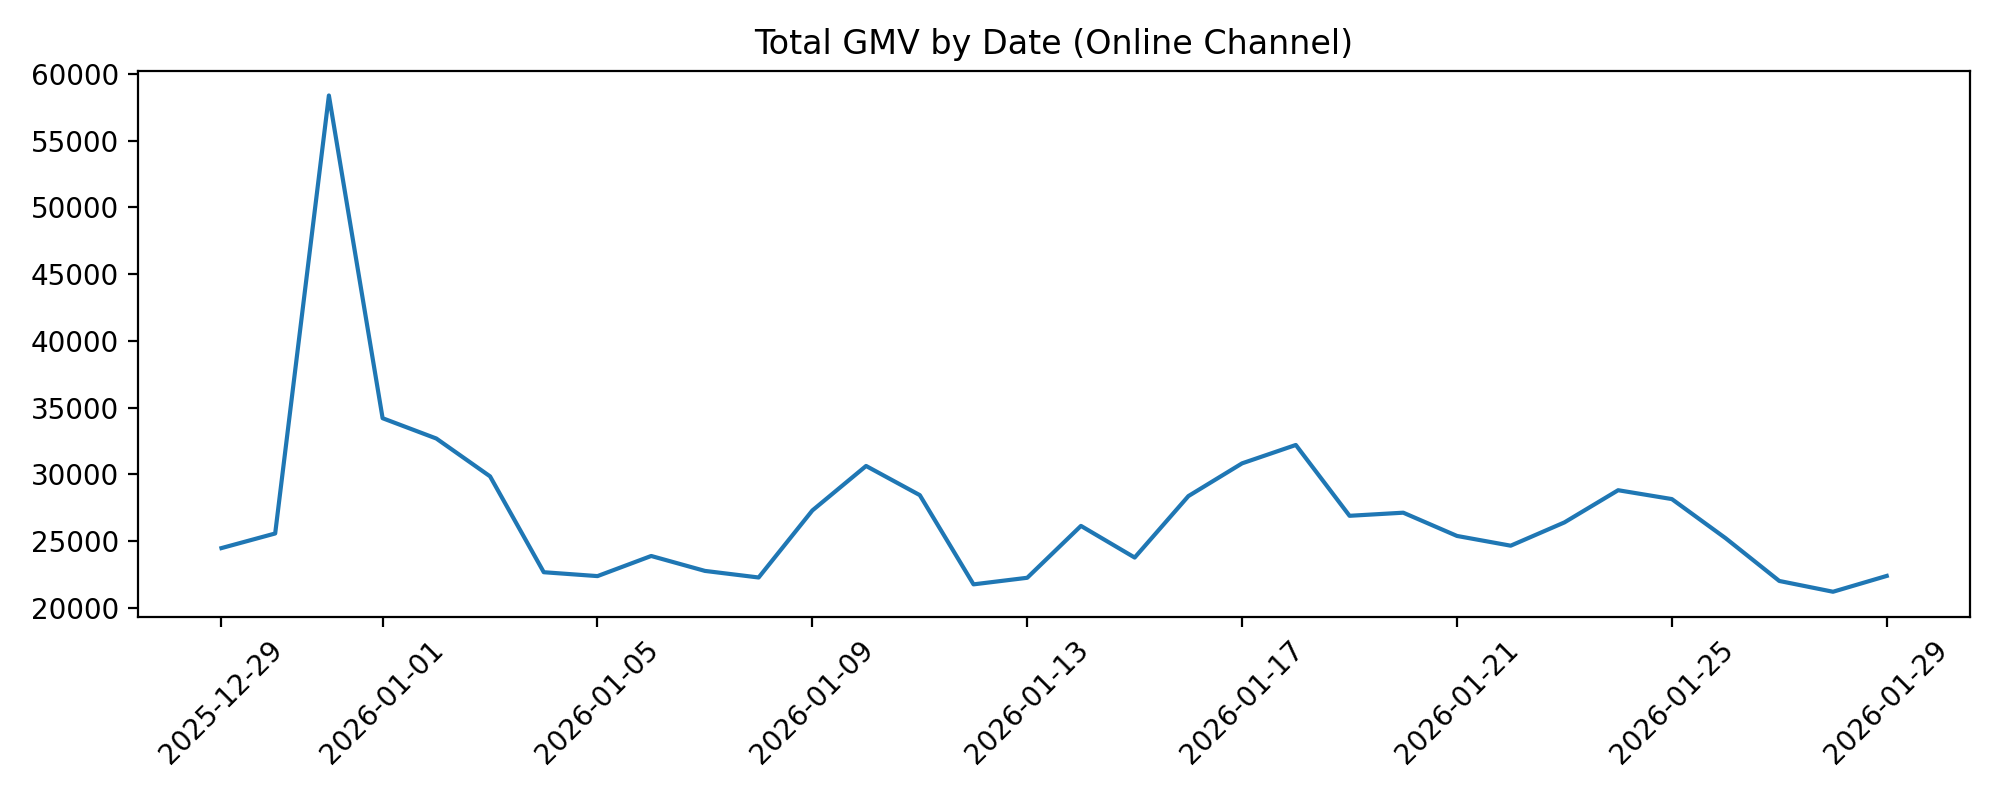

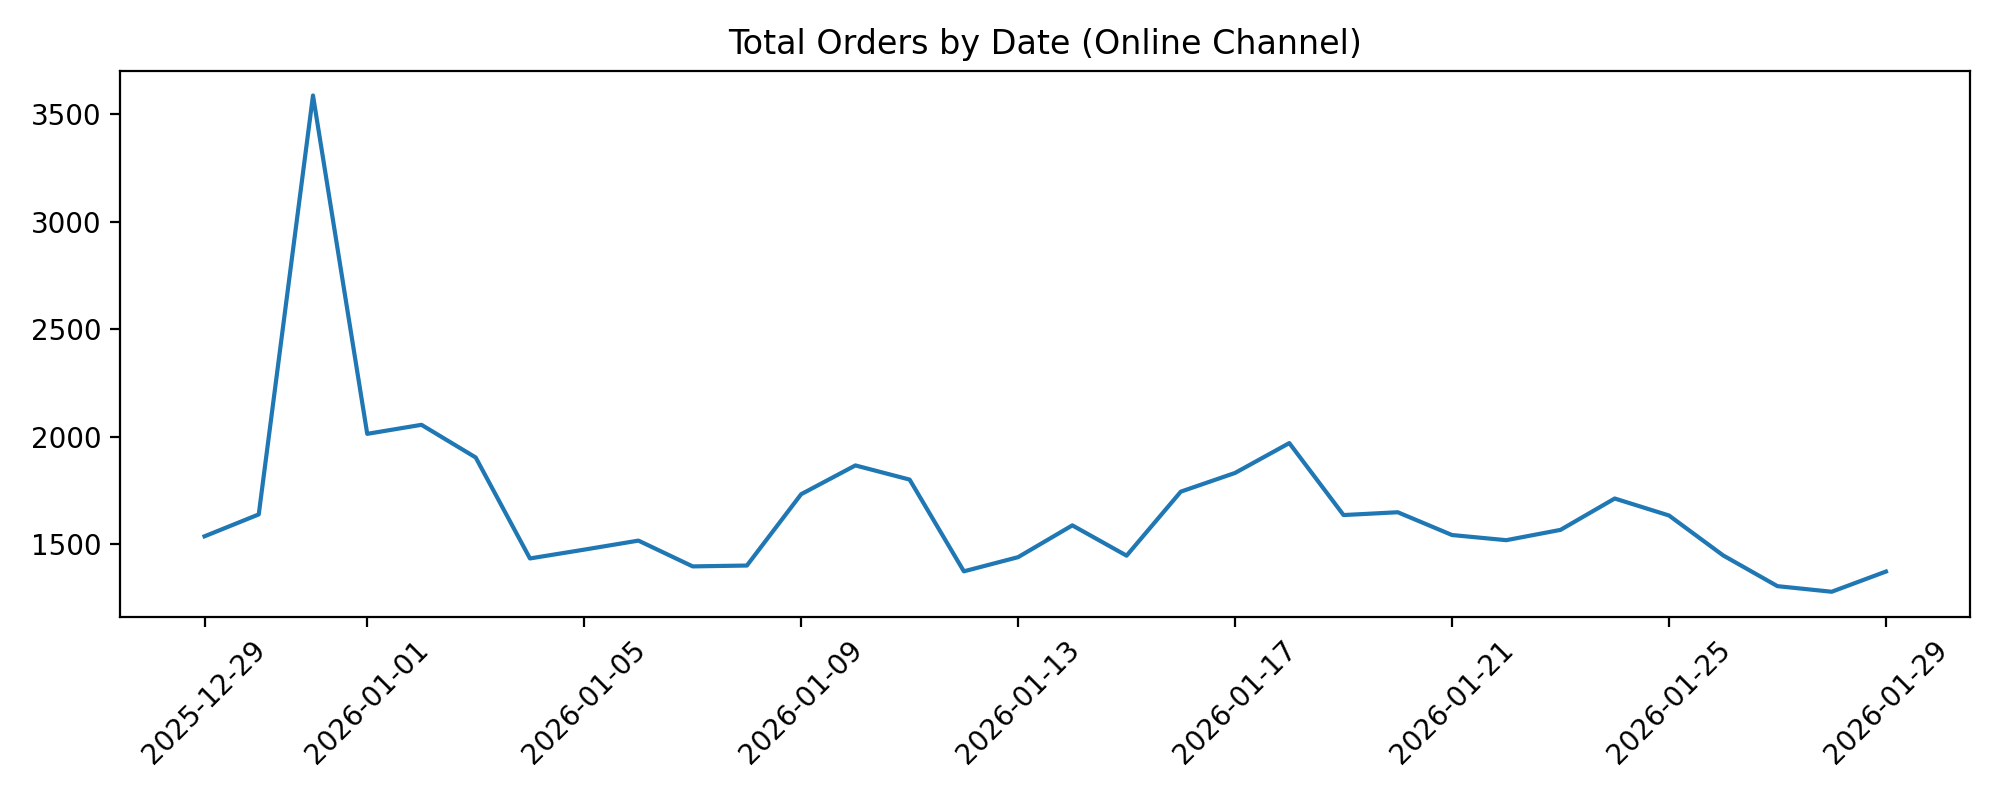

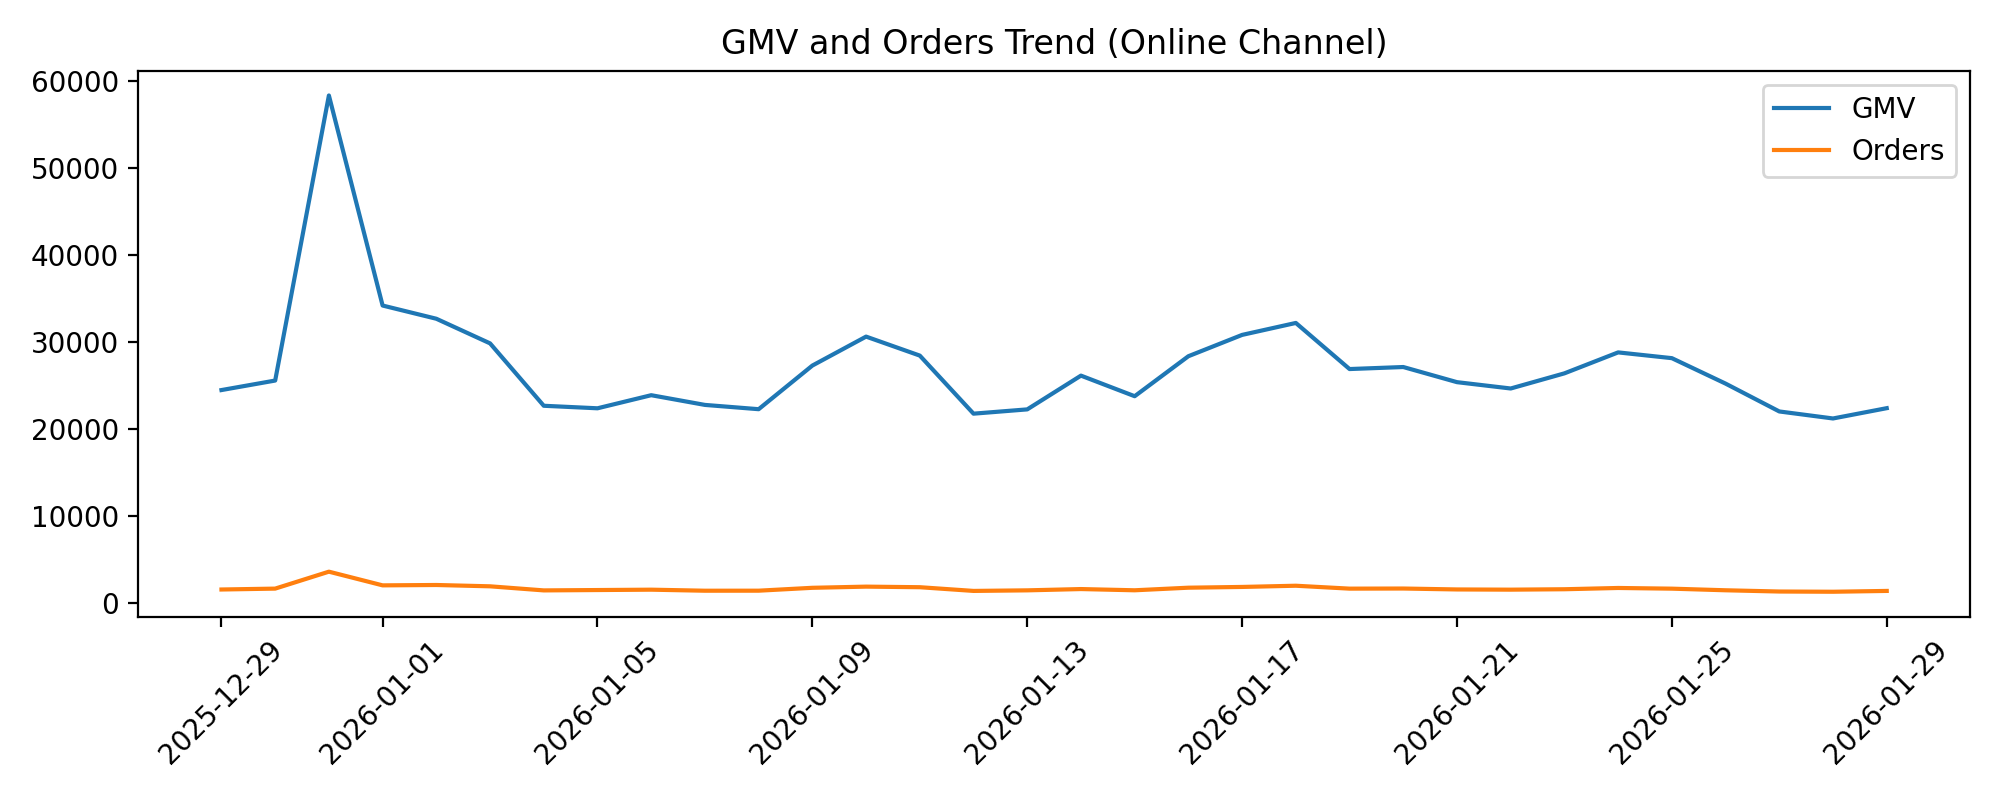

In [15]:
for fn in ['fig1_total_gmv_trend.png', 'fig2_total_orders_trend.png', 'fig6_gmv_vs_orders.png']:
    p = OUT_PUBLIC / fn
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print('skip missing:', fn)


**解读要点：**
- GMV 与 Orders 的走势高度同步，提示 GMV 下滑主要由订单侧驱动，而不是单纯的客单价变化。
- 存在明显峰值日（跨年附近），这类峰值通常对应“节假日/平台活动/供给变化”等，需要在后续贡献分析中确认是哪些门店拉动。


## 3.2 量价拆解：下滑主要来自 Orders 还是 AOV？
使用恒等式：

> **GMV = Orders × AOV**

我们比较窗口期（first7 vs last7）来判断主驱动来自哪一侧：
- 如果 Orders 下滑更明显 → 主因在订单侧（流量/转化/营业等）
- 如果 AOV 下滑更明显 → 主因在客单侧（定价/券补贴/结构等）


In [17]:
tab1 = pd.read_csv(OUT_PUBLIC / "tab1_window_summary.csv")
tab1


,window,gmv,qty,orders,aov,items_per_order
0,first7,227899.82,16550,14166,16.09,1.168
1,last7,174262.01,11942,10312,16.90,1.158


**结论：**
- 窗口期对比显示 GMV 下滑的同时，Orders 下降更明显，而 AOV 并未走弱甚至上升，说明下滑的主驱动来自**订单侧（Orders）**。
- 注意：AOV 的变化可能包含“品类结构变化/券补贴强弱变化/配送费口径”等因素，因此在缺少补贴与曝光数据的情况下，本项目仅将其作为“拆解结果”，不直接推断为商家定价变化。


## 3.3 贡献分析：哪些门店贡献了主要下滑？
当整体下滑成立后，下一步不是“平均分析”，而是定位“贡献最大/问题最集中”的门店，这样才能提高排查效率。


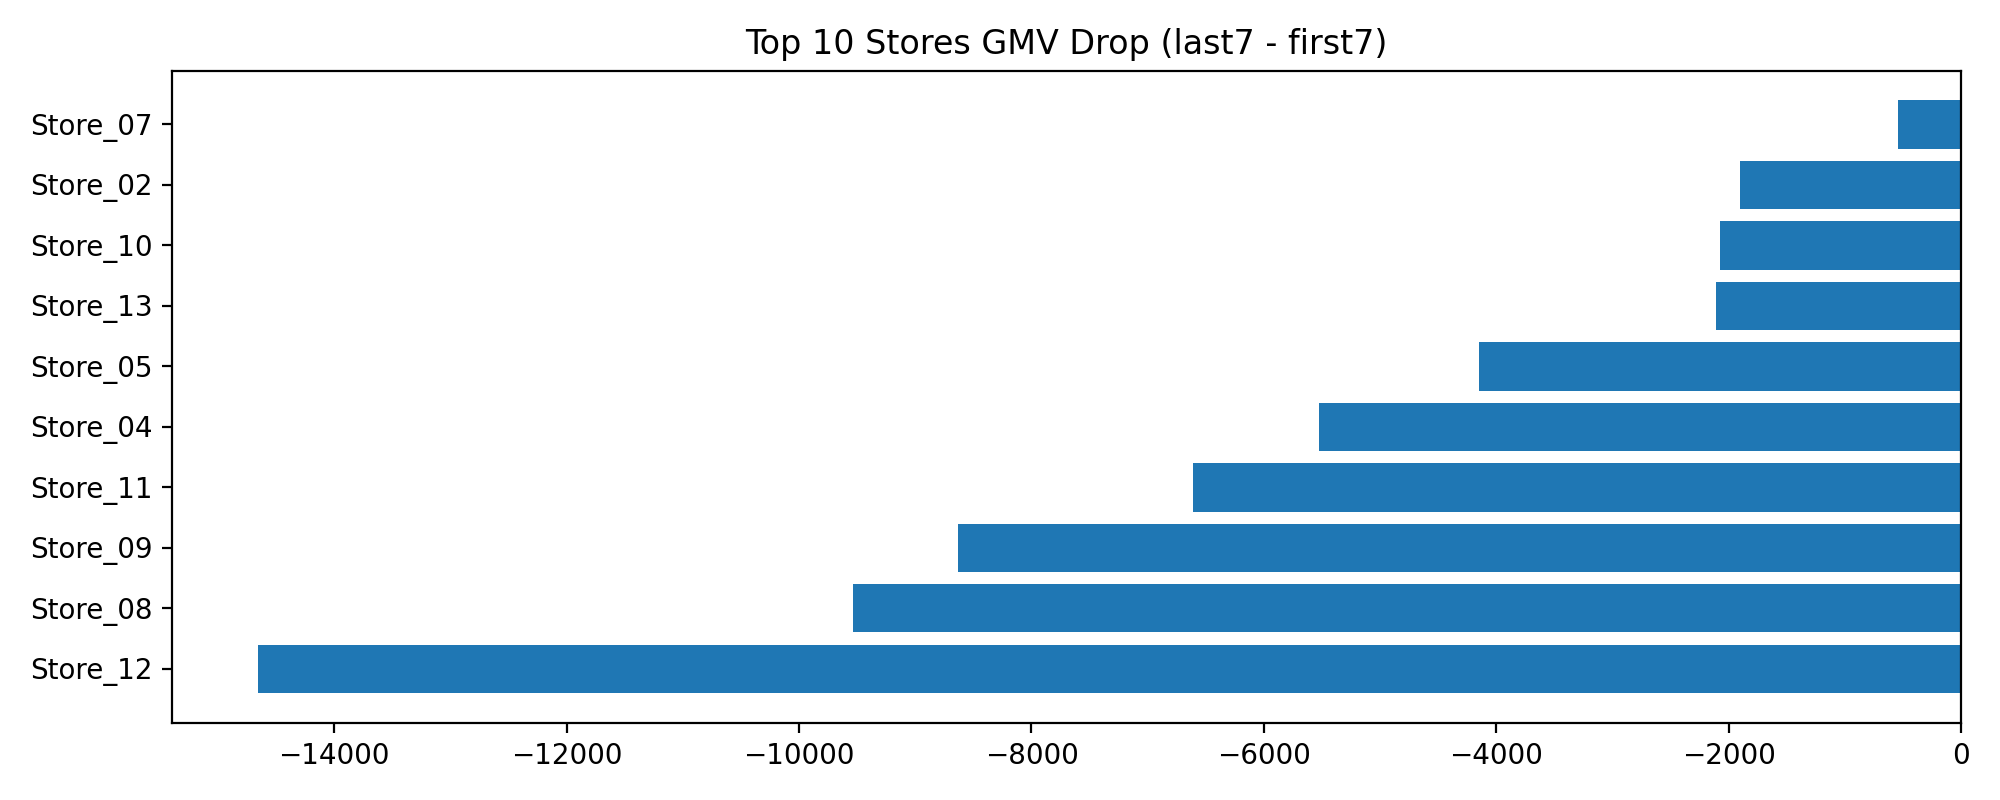

,store_code,store_name_public,delta_gmv,delta_oneprice_share,oneprice_share_first7,oneprice_share_last7
0,S12,Store_12,-14658.50,0.239947,0.0,0.239947
1,S08,Store_08,-9537.70,0.159538,0.0,0.159538
2,S09,Store_09,-8627.84,0.247954,0.0,0.247954
3,S11,Store_11,-6610.90,0.251636,0.0,0.251636
4,S04,Store_04,-5529.70,0.256624,0.0,0.256624
5,S05,Store_05,-4145.00,0.186528,0.0,0.186528
6,S13,Store_13,-2112.20,0.297402,0.0,0.297402
7,S10,Store_10,-2076.50,0.000000,0.0,0.000000
8,S02,Store_02,-1903.40,0.184664,0.0,0.184664
9,S07,Store_07,-540.90,0.000000,0.0,0.000000


In [18]:
display(Image(filename=str(OUT_PUBLIC / "fig3_top10_gmv_drop.png")))

tab2 = pd.read_csv(OUT_PUBLIC / "tab2_top10_drop_with_oneprice.csv")
tab2.head(10)


**解读要点：**
- 下滑贡献呈现“少数门店贡献大部分波动”的特征（典型帕累托现象），说明排查应优先聚焦 Top 下滑门店。
- 对这些门店，后续建议优先排查：营业时段、SKU供给、评价/差评、活动配置、出餐/履约等可能影响转化与复购的因素。


## 3.4 结构变化信号：一口价渗透是否发生变化？
一口价不是“原因结论”，而是“结构变化信号”。  
如果一口价渗透快速上升，可能意味着：
- 平台活动机制变化（入口曝光变了）
- 商家策略变化（以更强促销换订单）
- 用户侧偏好变化（更追求低价/确定性）

因此我们观察：**一口价GMV占比随时间的变化**。


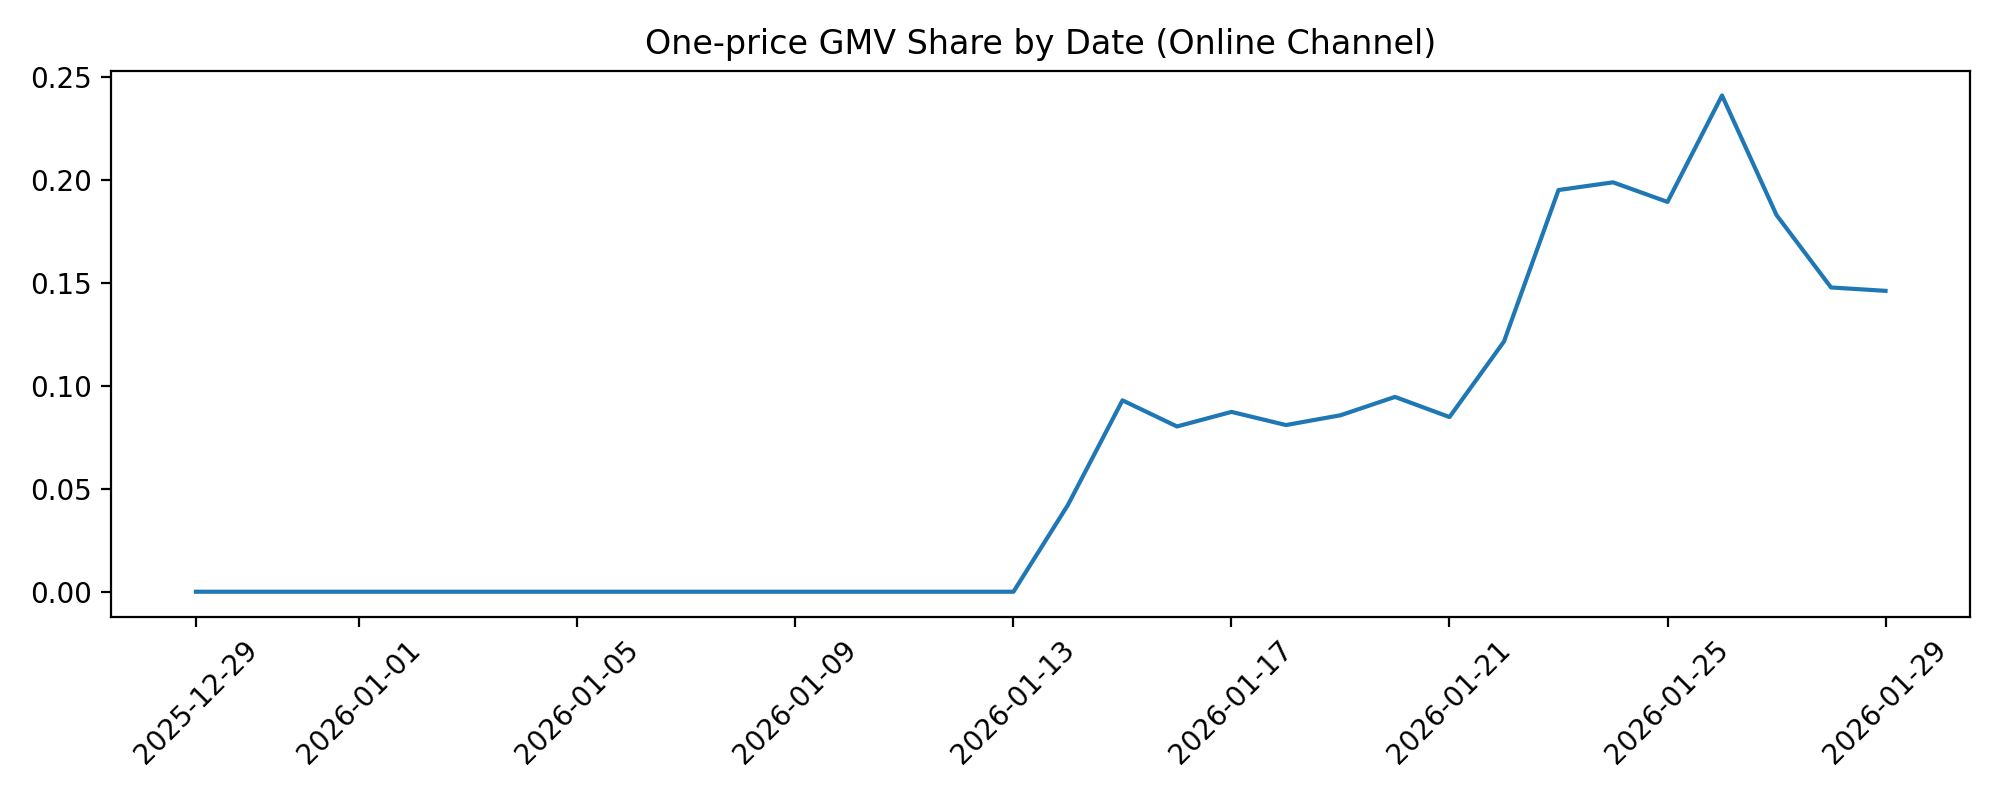

In [19]:
display(Image(filename=str(OUT_PUBLIC / "fig4_oneprice_share_trend.png")))


## 3.5 验证分析（Option B）：一口价变化与 GMV 下滑是否同向？
为避免“过度解读单一现象”，我们用两种方式做验证：

1) **相关性检验（散点图 + corr）**：观察门店层面一口价占比变化与 GMV 变化的方向关系（仅相关，不代表因果）。  
2) **分组对比（low/mid/high）**：将门店按一口价变化分组，比较各组的 GMV 下滑程度。

> 重要：本项目数据缺少曝光/补贴/转化等关键变量，因此这里只做“候选线索”的验证，而非因果推断。


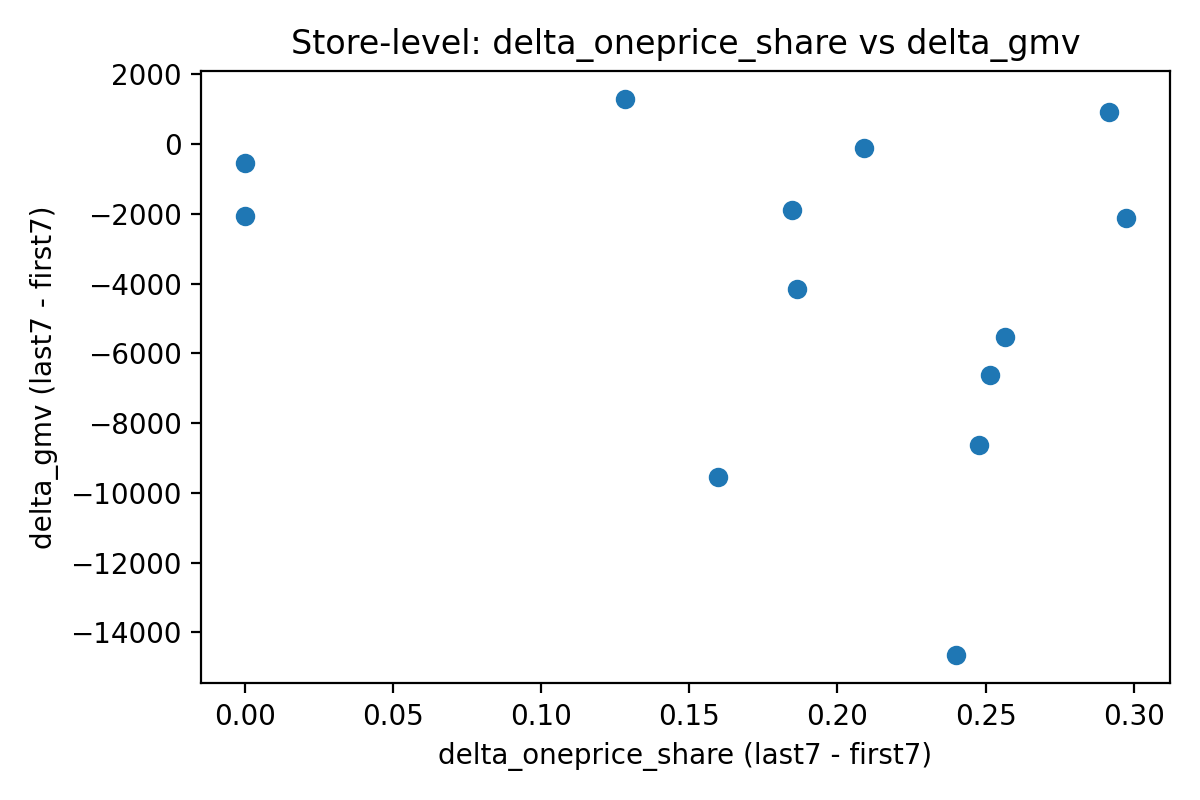

In [20]:
display(Image(filename=str(OUT_PUBLIC / "fig5_scatter_oneprice_vs_deltagmv.png")))


In [21]:
tab3 = pd.read_csv(OUT_PUBLIC / "tab3_bucket_oneprice_vs_deltagmv.csv")
tab3


,bucket,n,avg_delta_gmv,median_delta_gmv,avg_delta_oneprice
0,low,5,-2551.1000,-1903.40,0.094513
1,mid,4,-6886.7850,-6386.42,0.220813
2,high,4,-3333.7925,-3820.95,0.274377


**结论（克制且专业）：**
- 门店层面，一口价占比变化与 GMV 变化呈现弱相关（整体趋势可见但不强）。
- 分组结果并非严格单调，说明 GMV 下滑往往不是单一因素造成，而是“供给/流量/转化/活动策略”等混杂共同作用。
- 因此：一口价更适合作为“结构变化线索”，用于锁定需要进一步排查的门店，而不是直接当作原因定论。


## 3.6 供给侧检查：动销SKU是否同步走弱？
在外卖场景里，订单量下滑可能来自需求侧（流量/转化）也可能来自供给侧（SKU下架、缺货、套餐结束等）。  
由于缺少菜单上架表，本项目用“动销SKU（当天有成交的商品数）”作为供给侧信号进行观察。


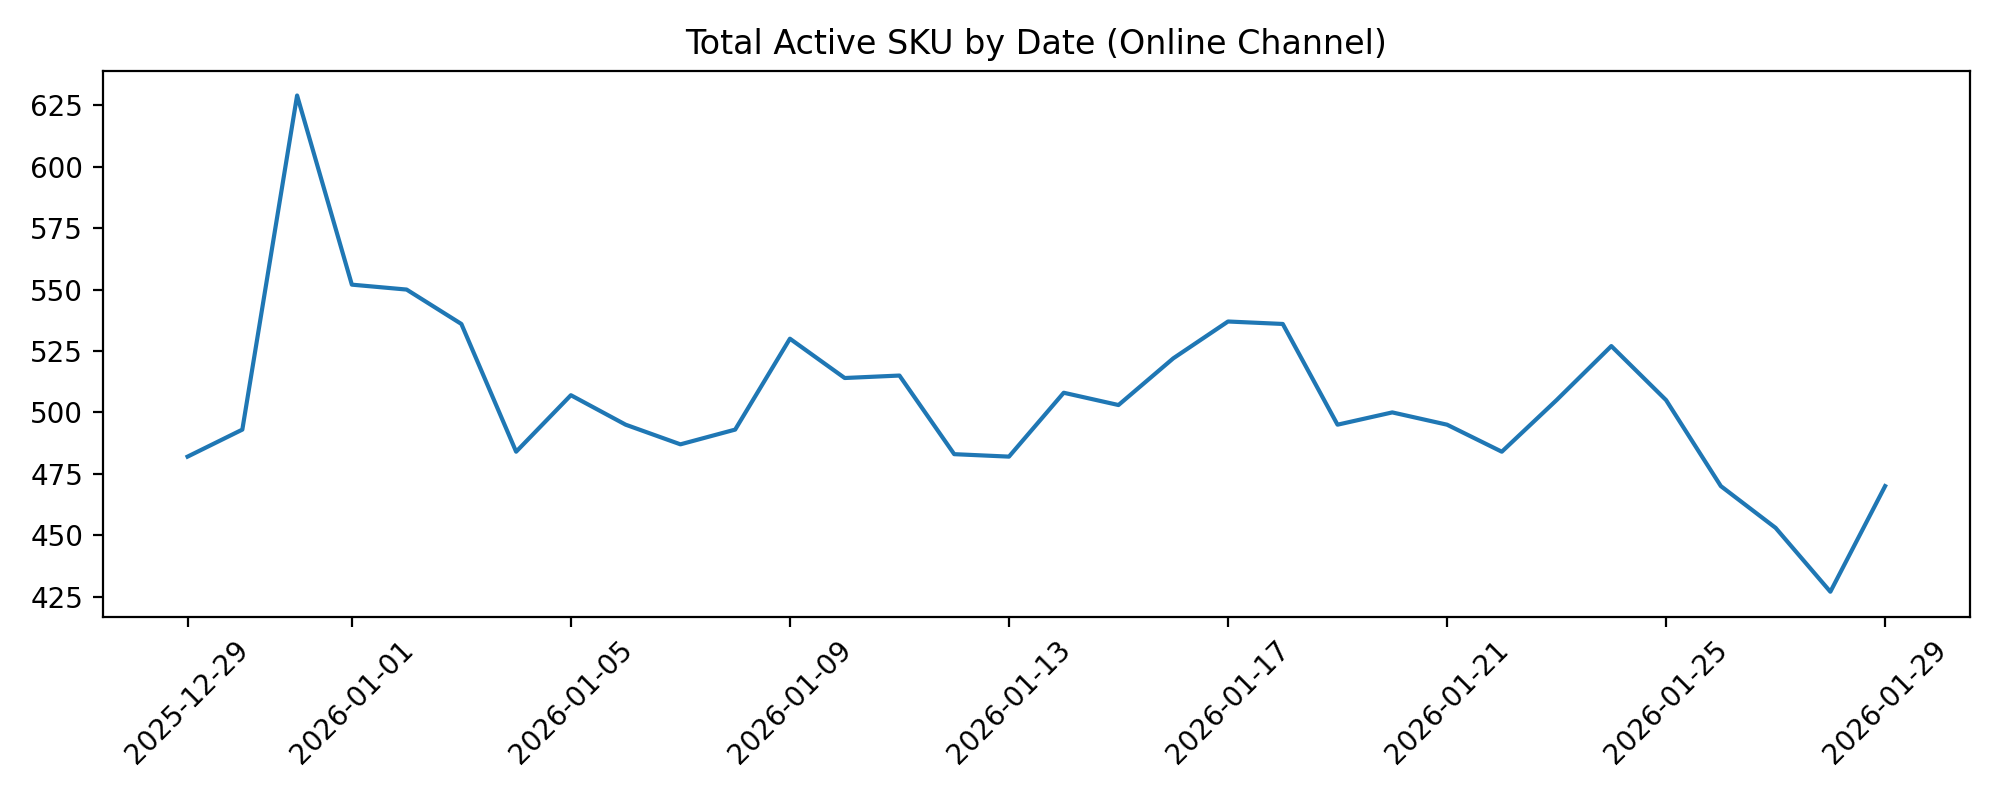

In [22]:
display(Image(filename=str(OUT_PUBLIC / "fig7_active_sku_trend.png")))


**解读要点：**
- 动销SKU在峰值日明显上升，说明高峰期“动销覆盖面扩大”。
- 但需注意：动销SKU上升既可能是“供给变丰富（上新/上架/套餐）”，也可能是“订单本身更多 → 覆盖更多商品”。  
  在缺少“菜单上架日志/商品上下架记录”的情况下，本项目将其作为**需要进一步验证的信号**。


# 4. 结论与建议（可执行）

## 4.1 三条关键发现
1) **主驱动在订单侧：**窗口期对比显示 GMV 下滑主要由 Orders 下滑驱动，AOV 并未走弱甚至上升。  
2) **下滑集中在少数门店：**贡献分析显示少数门店对整体下滑贡献显著，应优先聚焦 Top 下滑门店排查。  
3) **一口价是结构线索而非因果结论：**一口价渗透存在变化，与 GMV 下滑呈弱相关，建议作为排查线索使用。

## 4.2 建议（按优先级）
- **P0：排查供给侧与经营动作**
  - 对 Top 下滑门店核查：是否有SKU下架/缺货、套餐活动结束、营业时段缩短、履约变差导致转化下降。
- **P1：补充关键链路数据做进一步拆解**
  - 若能补充曝光/点击/转化数据，可将 Orders 拆成 Exposure×CTR×CVR，判断到底是流量还是转化问题。
- **P2：把结构信号变成可验证实验**
  - 针对“一口价渗透变化明显”的门店，设计对照组（同城同类门店）与AB验证，评估是否存在可持续的GMV提升策略。

## 4.3 局限性
- 数据仅覆盖单一外卖平台线上渠道，不代表门店全渠道经营表现。  
- 缺少曝光/补贴/菜单上架等关键变量，因此本项目主要做诊断与线索验证，避免因果推断。


# 附录：核心指标的 SQL 表达（逻辑等价）

> 说明：本项目实际分析用 pandas 完成；这里给出 **SQL 等价表达**，用于展示“我也能用 SQL 搭指标口径”。

```sql
-- A) 日粒度 GMV / Orders（来自 store_day 这张“门店×天”汇总表）
SELECT
  date,
  SUM(gmv)    AS gmv,
  SUM(orders) AS orders
FROM store_day
GROUP BY date
ORDER BY date;

-- B) 门店×天 store_day 的生成逻辑（来自 raw_order_items 订单商品明细）
SELECT
  date,
  store_id,
  store_name_public,
  SUM(item_gmv) AS gmv,
  SUM(item_qty) AS qty,
  SUM(orders)   AS orders,
  COUNT(DISTINCT product_name) AS active_sku
FROM raw_order_items
GROUP BY date, store_id, store_name_public;